This notebook analyzes data from https://github.com/HuthLab/deep-fMRI-dataset. To set up, see instructions in the `deep-fMRI-dataset` folder.

In [4]:
%load_ext autoreload
%autoreload 2
import datasets
import numpy as np
import sys
sys.path.append('..')
from os.path import join
from ridge_utils.SemanticModel import SemanticModel
from matplotlib import pyplot as plt
from typing import List
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer
from feature_spaces import em_data_dir, data_dir, results_dir
from collections import defaultdict
import pandas as pd
import os
import seaborn as sns
# from fit_linear_models import get_dsets
from ridge_utils.SemanticModel import SemanticModel
import encoding_utils, feature_spaces
from transformers.pipelines.pt_utils import KeyDataset
from feature_spaces import *
from transformers import pipeline
import datasets
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
save_dir = '/home/chansingh/mntv1/deep-fMRI/results/linear_models/oct17'
# save_dir = '/home/chansingh/mntv1/deep-fMRI/results/linear_models/subsamp_oct17'
dfs = []
fnames = os.listdir(save_dir)[::-1]
for fname in tqdm(fnames):
    df = pd.read_pickle(join(save_dir, fname))
    # print(fname)
    # display(df)
    dfs.append(df.reset_index())
d = pd.concat(dfs).drop(columns='coef_')
# .round(2)
# d.set_index(['feats', 'dset'], inplace=True)
d

100%|██████████| 45/45 [00:15<00:00,  2.83it/s]


,feats,dset,acc,feats_dim
0,glovevecs,tweet_eval,0.69,300
0,glovevecs,tweet_eval,0.69,300
0,glovevecs,tweet_eval,0.68,300
0,glove__ndel=4fmri,tweet_eval,0.68,1912
0,glove__ndel=4fmri,tweet_eval,0.68,1912
0,glove__ndel=4fmri,tweet_eval,0.68,1912
0,bert-base-uncased,tweet_eval,0.74,768
0,bert-base-uncased,tweet_eval,0.74,768
0,bert-base-uncased,tweet_eval,0.74,768
0,glovevecs,sst2,0.79,300


In [7]:
d.round(5)

,feats,dset,acc,feats_dim
0,glovevecs,tweet_eval,0.69,300
0,glovevecs,tweet_eval,0.69,300
0,glovevecs,tweet_eval,0.68,300
0,glove__ndel=4fmri,tweet_eval,0.68,1912
0,glove__ndel=4fmri,tweet_eval,0.68,1912
0,glove__ndel=4fmri,tweet_eval,0.68,1912
0,bert-base-uncased,tweet_eval,0.74,768
0,bert-base-uncased,tweet_eval,0.74,768
0,bert-base-uncased,tweet_eval,0.74,768
0,glovevecs,sst2,0.79,300


In [10]:
d

,feats,dset,acc,feats_dim
0,glovevecs,tweet_eval,0.686000,300
0,glovevecs,tweet_eval,0.686000,300
0,glovevecs,tweet_eval,0.683000,300
0,glove__ndel=4fmri,tweet_eval,0.685000,1912
0,glove__ndel=4fmri,tweet_eval,0.680000,1912
0,glove__ndel=4fmri,tweet_eval,0.685000,1912
0,bert-base-uncased,tweet_eval,0.741000,768
0,bert-base-uncased,tweet_eval,0.741000,768
0,bert-base-uncased,tweet_eval,0.743000,768
0,glovevecs,sst2,0.788991,300


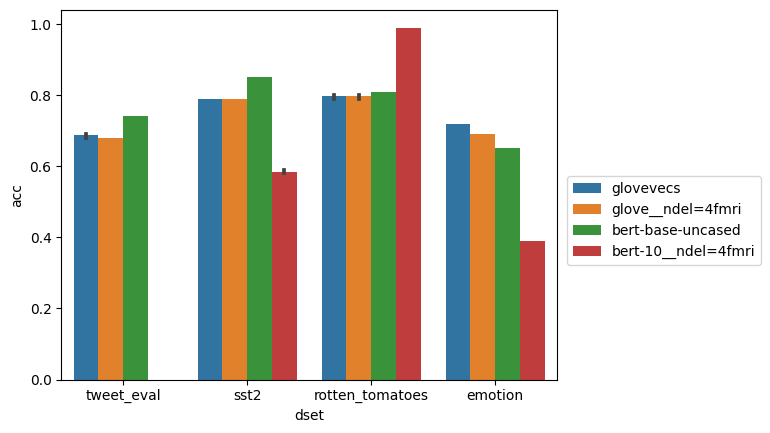

In [5]:
sns.barplot(data=d, x='dset', y='acc', hue='feats')
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
plt.savefig('decoding_accs.pdf', bbox_inches='tight')
